# Fine tuning BERTimbau to perform Parts of Speech Tagging

```
Name: Marco Antonio Rocha Vinha;                   
Date: 19/01/2025;                                  
GitHub repo: https://github.com/marcoVinha/nlp-tp2 
```

This notebook fine tunes a BERTimbau model (`neuralmind/bert-base-portuguese-cased`, 110M parameters) in the Mac-Morpho dataset to perform a Parts of Speech Tagging (POS Tagging) task in portuguese.

The evaluation of this model's performance consists in:
- Calculating different metrics on the test dataset:
    - Per-class precision
    - Macro precision
    - Weighted precision
    - Macro recall
    - Weighted recall
    - F1 score
- Comparing these metrics with the ones obtained by a competitor model:
    - The competitor model is the `lisaterumi/postagger-portuguese`
    - This model is also a BERTimbau-based model
    - This model is also fine tuned to perform POS Tagging in the Mac-Morpho dataset

In practice, the model we'll fine tune aims to reproduce the results of the `lisaterumi/postagger-portuguese` model. This notebook will cover this process and divide the methodology into the following sessions:
- Exploring the dataset
- Fine tuning our model
- Evaluating the model
- Conclusions

In [1]:
dataset_name = "nilc-nlp/mac_morpho"
model_name = "neuralmind/bert-base-portuguese-cased"

# Exploring the dataset

From the official Mac-Morpho [web-page](http://nilc.icmc.usp.br/macmorpho/):

> Mac-Morpho is a corpus of Brazilian Portuguese texts annotated with part-of-speech tags. Its first version was released in 2003, and since then, two revisions have been made in order to improve the quality of the resource.

According to the [dataset manual](http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf), it is already split in a train, a validation and a test sub-sets, and it contains a total of 27 possible classes/tags. The following table shows the classes in our dataset:

| Tag |  Meaning (grammatical class in portuguese)|
| ------------------- | ------------------- |
|  ADJ |  Adjetivo |
|  ADV |  Advérbio |
|  ADV-KS |  Advérbio conjuntivo subordinado  |
|  ADV-KS-REL |   Advérbio relativo subordinado |
|  ART |  Artigo  |
|  CUR |  Moeda  |
|  IN |  Interjeição |
|  KC |  Conjunção coordenativa |
|  KS |  Conjunção subordinativa |
|  N |  Substantivo |
|  NPROP | Substantivo próprio |
|  NUM |  Número |
|  PCP |  Particípio |
|  PDEN |  Palavra denotativa |
|  PREP |  Preposição |
|  PROADJ |  Pronome Adjetivo |
|  PRO-KS |  Pronome conjuntivo subordinado |
|  PRO-KS-REL |  Pronome relativo conectivo subordinado |
|  PROPESS |  Pronome pessoal |
|  PROSUB |  Pronome nominal |
|  V | Verbo |
|  VAUX  | Verbo auxiliar |


## Load dataset from HuggingFace

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_name, trust_remote_code=True)

/root/nlp-tp2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating maps from label to ID and vice-versa

In [3]:
# Create the mappings that translate
# labels into class IDs and vice-versa

labels = dataset["train"].features["pos_tags"].feature.names

label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

## Loading the BERTimbau tokenizer from HuggingFace

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
)

In [5]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

## Tokenize and align dataset

The tokenization process (transforming words/tokens in numbers) is an already known sub-task in NLP tasks, so we'll skip any explanations. But one additional thing we'll do is **aligning** the labels with the correct tokens we want to classify.

Aligning, in this context, means *knowing what subwords/tokens of a word we want to tag*. When you tokenize a sentence, especially using subword tokenizers (which is the case with the tokenizer we're using), the sentence is split into subword tokens. Because of this, we need to ensure that the labels are correctly associated with these tokens. This is where label alignment comes into play.

In our dataset, each word has a single label, but tokenization may result in subwords. In the end of our tokenization process, the number of tokens often exceeds the number of original words. For example:
- Imagine our labels look something like: `label2id = {"NOUN": 0, "VERB": 1, ...}`
- Now imagine that we're trying to classify the word `playing` into a `VERB`
- When we tokenized the word, it is broken into **two tokens**: `["play", "ing"]`
- What should we tag as a `VERB`: `play`, or `ing`?

Hopefully, you can see why that's a problem. In this case, we'll fix this by "aligning" our dataset:
1. The first token of a word (in our case, `play`) will be tagged with the original word's label (in our case, `VERB`, with value `1`).
2. The following tokens, will be ignored if we assign a special value/class to it. Typically, when we assign the value of `-100`, our model is already able to ignore the token, excluding it from the loss function calculation during training.




In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, padding=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            elif word_id != previous_word_id:
                aligned_labels.append(label[word_id])
            else:
                aligned_labels.append(-100)
            previous_word_id = word_id
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

# Fine tuning our model

Finally, we'll fine tune our model. For this experiment, we'll train our model for only $5$ epochs, and we'll use a learning rate of $5\mathrm{e}{-5}$. Our dataset is split in train (37948 samples), validation (1997 samples) and test (9987 samples) sub-sets.

## Download model from HuggingFace

In [7]:
from transformers import AutoModelForTokenClassification


model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

model.to("cuda")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## Define fine tuning routine

### Defining custom metrics to evaluate model

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


def compute_metrics(p):
    predictions, labels = p

    # Get predicted labels by taking argmax
    predictions = np.argmax(predictions, axis=-1)

    # Flatten and filter out ignored tokens (-100)
    true_labels = labels.flatten()
    pred_labels = predictions.flatten()
    mask = true_labels != -100
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]

    # Compute metrics
    macro_precision = precision_score(
        true_labels, pred_labels, average="macro", zero_division=0
    )
    weighted_precision = precision_score(
        true_labels, pred_labels, average="weighted", zero_division=0
    )
    macro_recall = recall_score(
        true_labels, pred_labels, average="macro", zero_division=0
    )
    weighted_recall = recall_score(
        true_labels, pred_labels, average="weighted", zero_division=0
    )
    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)
    per_class_precision = precision_score(
        true_labels, pred_labels, average=None, zero_division=0
    )

    # Map class indices to precision values
    unique_tags = np.unique(true_labels)
    per_class_precision_dict = {
        id2label[int(tag)]: float(per_class_precision[i])
        for i, tag in enumerate(unique_tags)
    }

    return {
        "macro_precision": macro_precision,
        "weighted_precision": weighted_precision,
        "macro_recall": macro_recall,
        "weighted_recall": weighted_recall,
        "f1_score": f1,
        "per_class_precision": per_class_precision_dict,
    }

In [9]:
from transformers import TrainingArguments, Trainer

# Training with be used with the `Trainer`
# API provided by `transformers`
training_args = TrainingArguments(
    output_dir=".results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=5,
    save_strategy="epoch",
    use_cpu=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

/root/nlp-tp2/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [10]:
# The function call that actually trains our model

trainer.train()

Epoch,Training Loss,Validation Loss,Macro Precision,Weighted Precision,Macro Recall,Weighted Recall,F1 Score,Per Class Precision
1,0.065500,0.062208,0.952511,0.982815,0.930139,0.982845,0.982786,"{'PREP+PROADJ': 1.0, 'IN': 0.8333333333333334, 'PREP+PRO-KS': 0.7692307692307693, 'NPROP': 0.9722730839654722, 'PREP+PROSUB': 0.84, 'KC': 0.9860064585575888, 'PROPESS': 0.9953271028037384, 'NUM': 0.9824304538799414, 'PROADJ': 0.9782244556113903, 'PREP+ART': 0.9901356350184957, 'KS': 0.9137931034482759, 'PRO-KS': 0.9342105263157895, 'ADJ': 0.9686985172981878, 'ADV-KS': 0.8709677419354839, 'N': 0.9840791219394525, 'PREP': 0.9792759706190975, 'PROSUB': 0.9137254901960784, 'PREP+PROPESS': 1.0, 'PDEN': 0.9459459459459459, 'V': 0.9962311557788944, 'PREP+ADV': 1.0, 'PCP': 0.9819277108433735, 'CUR': 0.991304347826087, 'ADV': 0.9494623655913978, 'PU': 0.9996507160321342, 'ART': 0.989041095890411}"
2,0.047500,0.058187,0.958043,0.984647,0.949189,0.984671,0.984618,"{'PREP+PROADJ': 1.0, 'IN': 0.9, 'PREP+PRO-KS': 0.7692307692307693, 'NPROP': 0.9809825673534073, 'PREP+PROSUB': 0.875, 'KC': 0.9945652173913043, 'PROPESS': 0.9884526558891455, 'NUM': 0.9798850574712644, 'PROADJ': 0.9814502529510961, 'PREP+ART': 0.9909725071809602, 'KS': 0.9279475982532751, 'PRO-KS': 0.9302832244008714, 'ADJ': 0.9777530589543938, 'ADV-KS': 0.8823529411764706, 'N': 0.9808726838015541, 'PREP': 0.9844409282700421, 'PROSUB': 0.9372384937238494, 'PREP+PROPESS': 1.0, 'PDEN': 0.9128630705394191, 'V': 0.9967344888219041, 'PREP+ADV': 1.0, 'PCP': 0.9842995169082126, 'CUR': 0.991304347826087, 'ADV': 0.9500531349628055, 'PU': 1.0, 'ART': 0.9924294562973159}"
3,0.026400,0.066354,0.961181,0.984535,0.949472,0.984517,0.984499,"{'PREP+PROADJ': 1.0, 'IN': 1.0, 'PREP+PRO-KS': 0.8181818181818182, 'NPROP': 0.9719698935894109, 'PREP+PROSUB': 0.8518518518518519, 'KC': 0.9870410367170627, 'PROPESS': 0.9930232558139535, 'NUM': 0.9826338639652678, 'PROADJ': 0.9767054908485857, 'PREP+ART': 0.9917593737124022, 'KS': 0.9237472766884531, 'PRO-KS': 0.9307359307359307, 'ADJ': 0.9637249593936112, 'ADV-KS': 0.8484848484848485, 'N': 0.9882409989089587, 'PREP': 0.986744432661718, 'PROSUB': 0.9317269076305221, 'PREP+PROPESS': 1.0, 'PDEN': 0.9380530973451328, 'V': 0.9959869576122398, 'PREP+ADV': 1.0, 'PCP': 0.9841463414634146, 'CUR': 0.991304347826087, 'ADV': 0.9428868120456906, 'PU': 0.9996508379888268, 'ART': 0.9920935029219663}"
4,0.014000,0.078248,0.961334,0.984847,0.948349,0.984851,0.984825,"{'PREP+PROADJ': 1.0, 'IN': 1.0, 'PREP+PRO-KS': 0.7692307692307693, 'NPROP': 0.9769512833944474, 'PREP+PROSUB': 0.8461538461538461, 'KC': 0.9881465517241379, 'PROPESS': 0.9930394431554525, 'NUM': 0.9755747126436781, 'PROADJ': 0.9768595041322314, 'PREP+ART': 0.9921681780708986, 'KS': 0.9259259259259259, 'PRO-KS': 0.9424778761061947, 'ADJ': 0.9674972914409534, 'ADV-KS': 0.90625, 'N': 0.9858763882182521, 'PREP': 0.9864864864864865, 'PROSUB': 0.9212598425196851, 'PREP+PROPESS': 1.0, 'PDEN': 0.9279661016949152, 'V': 0.9957350727546412, 'PREP+ADV': 1.0, 'PCP': 0.9794437726723095, 'CUR': 0.991304347826087, 'ADV': 0.9545934530095037, 'PU': 1.0, 'ART': 0.9917412250516173}"
5,0.005700,0.088842,0.962042,0.985236,0.956987,0.985237,0.985218,"{'PREP+PROADJ': 1.0, 'IN': 1.0, 'PREP+PRO-KS': 0.7692307692307693, 'NPROP': 0.9752152361074876, 'PREP+PROSUB': 0.8461538461538461, 'KC': 0.9849624060150376, 'PROPESS': 0.9930394431554525, 'NUM': 0.9770114942528736, 'PROADJ': 0.9784768211920529, 'PREP+ART': 0.9921649484536083, 'KS': 0.9342105263157895, 'PRO-KS': 0.9426048565121413, 'ADJ': 0.970108695652174, 'ADV-KS': 0.90625, 'N': 0.9873096446700508, 'PREP': 0.9864864864864865, 'PROSUB': 0.9206349206349206, 'PREP+PROPESS': 1.0, 'PDEN': 0.9399141630901288, 'V': 0.9962339944765253, 'PREP+ADV': 1.0, 'PCP': 0.9818621523579202, 'CUR': 0.991304347826087, 'ADV': 0.9468196037539103, 'PU': 0.9996508379888268, 'ART': 0.9934460158675406}"


TrainOutput(global_step=23720, training_loss=0.03762265246292391, metrics={'train_runtime': 1713.5329, 'train_samples_per_second': 110.73, 'train_steps_per_second': 13.843, 'total_flos': 1.835607201292267e+16, 'train_loss': 0.03762265246292391, 'epoch': 5.0})

# Evaluating the model

## Against test data

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math


def plot_class_precisions(per_class_precision):
    """
    Plots a bar chart of precision scores for each class.

    Args:
    - per_class_precision (dict): Dictionary mapping class names (e.g., "NOUN", "VERB") to precision scores.

    """
    # Extract class names and precision scores
    class_names = list(per_class_precision.keys())
    precision_scores = list(per_class_precision.values())

    # Sort by precision (descending order)
    sorted_indices = np.argsort(precision_scores)[::-1]
    sorted_class_names = [class_names[i] for i in sorted_indices]
    sorted_precisions = [precision_scores[i] for i in sorted_indices]

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_class_names, sorted_precisions, color="skyblue", edgecolor="black")

    # Add labels and title
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title("Precision per Class (Sorted)", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.ylim(0, 1)  # Precision values are between 0 and 1

    # Annotate the bars with precision values
    for i, precision in enumerate(sorted_precisions):
        precision_shown = math.floor(precision * 100) / 100
        plt.text(i, precision, f"{precision_shown:.2f}", ha="center", fontsize=8)

    # Display the plot
    plt.tight_layout()
    plt.show()

### Analysing class distribution

To evaluate our model, we'll take a look at the class distribution of our test dataset. In this case, this is important because we care more about our model being right in the most present classes in our corpus. Of course, this might be true for this problem, but isn't an universal true for all NLP related tasks.

In [12]:
import matplotlib.pyplot as plt


def plot_class_distribution(dataset, label_column, id2label, threshold_percentage=1.0):
    """
    Plots a pie chart of the class distribution in a given dataset where the labels are lists of lists,
    showing the actual class names using `id2label`, with classes below a certain threshold percentage
    grouped into an "Other" category.

    Args:
    - dataset (Dataset): The dataset to analyze (HuggingFace Dataset).
    - label_column (str): The column name in the dataset that contains the class labels (lists of lists).
    - id2label (dict): A dictionary mapping class IDs (numeric values) to class names (text labels).
    - threshold_percentage (float): The percentage threshold below which classes will be grouped into the "Other" category.
    """
    # Extract the labels (lists of labels) from the dataset
    labels = dataset[label_column]

    # Flatten the list of lists to count all occurrences of the individual labels
    flat_labels = [label for sublist in labels for label in sublist]

    # Map class IDs to class names using `id2label`
    class_names = [id2label[label] for label in flat_labels]

    # Count the occurrences of each class
    class_counts = {
        class_name: class_names.count(class_name) for class_name in set(class_names)
    }

    # Calculate the total number of labels
    total_labels = len(flat_labels)

    # Sort classes by frequency (most frequent first)
    sorted_class_counts = dict(
        sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
    )

    # Identify classes with percentage below the threshold
    threshold_count = total_labels * (threshold_percentage / 100)

    # Group classes below the threshold percentage into 'Other'
    other_count = 0
    filtered_class_counts = {}
    for class_name, count in sorted_class_counts.items():
        if count < threshold_count:
            other_count += count
        else:
            filtered_class_counts[class_name] = count

    # Add 'Other' category if there are any classes below the threshold
    if other_count > 0:
        filtered_class_counts["Other"] = other_count

    # Prepare data for pie chart
    sorted_class_names = list(filtered_class_counts.keys())
    sorted_counts = list(filtered_class_counts.values())

    # Plot pie chart
    plt.figure(figsize=(10, 10))
    wedges, texts, autotexts = plt.pie(
        sorted_counts,
        labels=sorted_class_names,
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Paired.colors,
        textprops={"fontsize": 10},
        wedgeprops={"edgecolor": "black"},
    )

    # Make the labels and percentages more readable by adjusting the label distance and font size
    for text in texts + autotexts:
        text.set_fontsize(10)

    # Rotate the labels for better readability
    plt.setp(texts, rotation=45, ha="right")

    # Add a sorted legend with class names and percentages
    plt.legend(
        title="Classes",
        labels=[
            f"{name}: {count} ({count/total_labels*100:.1f}%)"
            for name, count in zip(sorted_class_names, sorted_counts)
        ],
        loc="upper left",
        fontsize=10,
        bbox_to_anchor=(1.0, 1.0),
    )

    # Set the title and aspect ratio
    plt.title("Class Distribution in Test Dataset", fontsize=14)
    plt.axis("equal")  # Equal aspect ratio ensures that pie chart is drawn as a circle.

    # Display the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

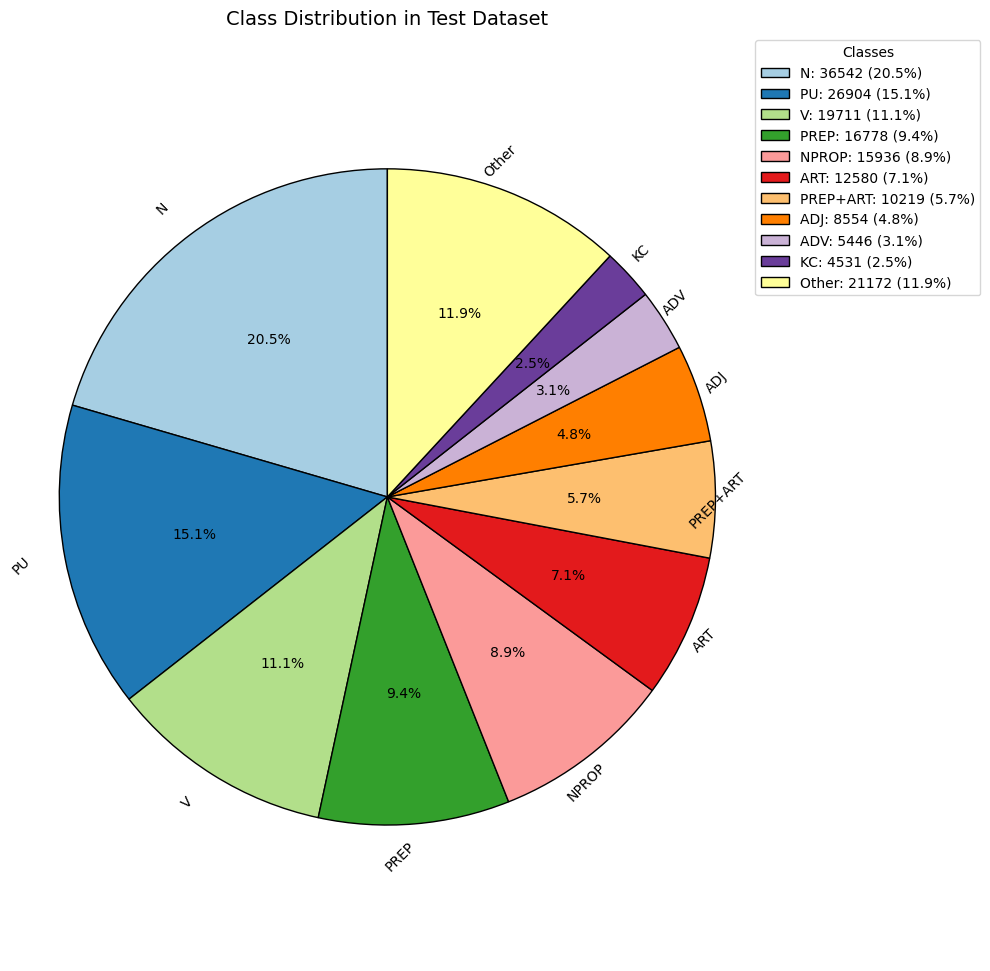

In [13]:
plot_class_distribution(
    tokenized_dataset["test"],
    label_column="pos_tags",
    id2label=id2label,
    threshold_percentage=2.5,
)

### Analyse model performance

Now, we can take a look about how our model actually performs on each class.

In [14]:
model_results = trainer.evaluate(tokenized_dataset["test"])

model_results

{'eval_loss': 0.12932297587394714,
 'eval_macro_precision': 0.9400093604551558,
 'eval_weighted_precision': 0.9808824499001022,
 'eval_macro_recall': 0.9472128165014748,
 'eval_weighted_recall': 0.9808210883934227,
 'eval_f1_score': 0.9808330468644628,
 'eval_per_class_precision': {'PREP+PROADJ': 0.9967637540453075,
  'IN': 0.5905511811023622,
  'PREP+PRO-KS': 0.8059701492537313,
  'NPROP': 0.9768361581920904,
  'PREP+PROSUB': 0.8866666666666667,
  'KC': 0.9851572884359769,
  'PROPESS': 0.9926778242677824,
  'NUM': 0.9721115537848606,
  'PROADJ': 0.9688772542175683,
  'PREP+ART': 0.9932392710170488,
  'KS': 0.9401294498381877,
  'PRO-KS': 0.9261538461538461,
  'ADJ': 0.9610086388045762,
  'ADV-KS': 0.8495575221238938,
  'N': 0.9821663740122915,
  'PREP': 0.9797477349440398,
  'PROSUB': 0.9221204188481675,
  'PREP+PROPESS': 1.0,
  'PDEN': 0.8890892696122633,
  'V': 0.9950274000405926,
  'PREP+ADV': 0.9333333333333333,
  'PCP': 0.9713340683572216,
  'CUR': 1.0,
  'ADV': 0.933407325194228

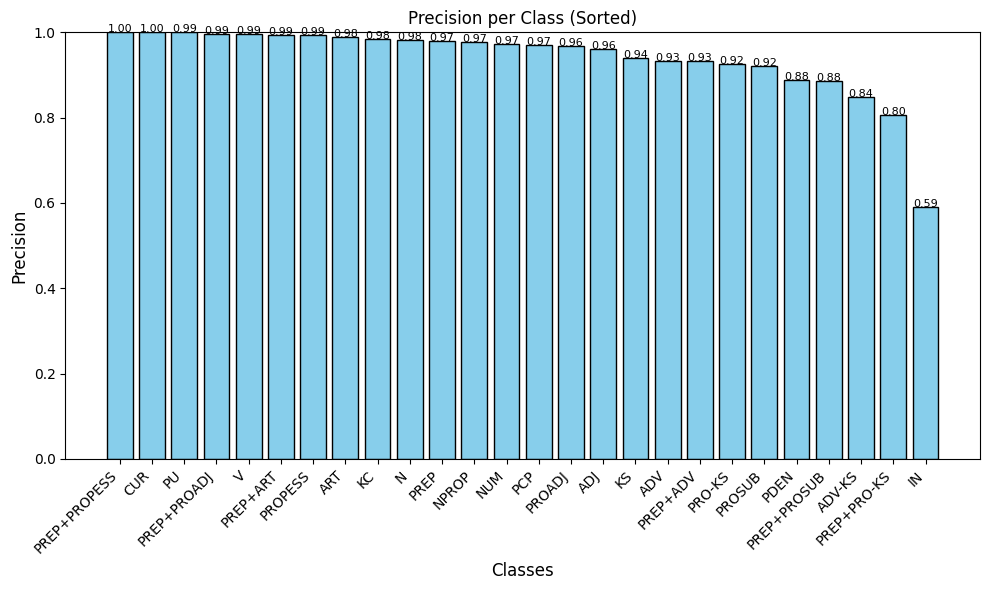

In [15]:
plot_class_precisions(model_results["eval_per_class_precision"])

# Conclusions

## Overall model performance

The `lisaterumi/postagger-portuguese` model reports the following metrics in its [HuggingFace page](https://huggingface.co/lisaterumi/postagger-portuguese) (among others):

```
              Precision  Recall 
accuracy                        
macro avg          0.96    0.95 
weighted avg       0.98    0.98 

F1:  0.9826
```

For the model we trained, these are the reports:

```
              Precision  Recall 
macro avg          0.94    0.95 
weighted avg       0.98    0.98 

F1:  0.98
```


## Evaluating per-class precision